# Analyzing the Birthplaces of NHL Players and Their Closest NHL Team

In [ ]:
# A voronoi map of the regions covered by the teams (of places in the U.S. and Canada) would be really cool, too

# Imports 

In [53]:
import pandas as pd
from functions import *
%run functions.py
import seaborn as sns

## Data

In [30]:
all_players_df = pd.read_csv('data/player_info_df.csv', index_col=0)
all_na_players_df = pd.read_csv('data/all_players_full_info.csv', index_col=0)

In [10]:
player_gdf = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf.drop(columns = ['link','Lat', 'Lng', 'geometry', 'nearest_geom', 'line'], inplace=True)

In [27]:
player_gdf.head(2)

,id,fullName,position,team_id,birthCity,birthStateProvince,birthCountry,nationality,team_name,city_province,coordinates,nearest_team,haversine_distance,close_to_any_team
0,8479414,Nathan Bastian,RW,1,Kitchener,ON,CAN,CAN,New Jersey Devils,"Kitchener,ON","43.4186,-80.4728",Toronto Maple Leafs,56.938564,True
1,8481740,Tyce Thompson,RW,1,Calgary,AB,CAN,CAN,New Jersey Devils,"Calgary,AB","51.05,-114.0667",Calgary Flames,1.076696,True


# Team Analysis

## How Many Players COULD Play for Closest Team

In [24]:
team_df = pd.DataFrame(player_gdf.groupby('nearest_team').id.count())

### Full teams

<AxesSubplot:xlabel='id'>

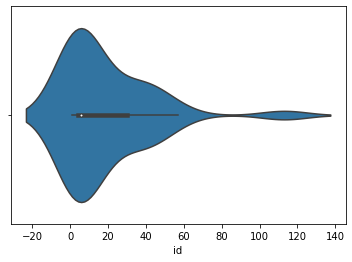

In [54]:
# distribution
sns.violinplot(x=team_df["id"])

In [49]:
# 11 teams would still be around!
# all 7 canadian teams plus one border team (Detroit, not Buffalo though)
team_df[team_df['id'] > 18].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


In [36]:
print(f"{round(all_na_players_df.shape[0] / all_players_df.shape[0], 2)*100}% of players are from NA")

70.0% of players are from NA


In [47]:
# A team roster has 18 players, normally
team_roster_count = player_gdf.shape[0] / player_gdf.team_name.nunique()

In [51]:
# Since 70% of players are from NA, how many teams have 70% of a roster? 13
## how many teams have more than 13 players born close to them? Same amount as before
team_df[team_df['id'] > 13].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


## Few Players

In [55]:
# lots of teh southern teams have 5 or fewer players
# Every team has at least one NHL-quality player near them. That's frankly surprising
team_df[team_df['id'] < 13].sort_values(by='id')

,id
nearest_team,
San Jose Sharks,1
Vegas Golden Knights,1
Florida Panthers,1
Nashville Predators,2
Carolina Hurricanes,2
Tampa Bay Lightning,3
New Jersey Devils,4
Los Angeles Kings,4
Washington Capitals,4


# Players Playing for Home Team

In [57]:
home_team = player_gdf[player_gdf['team_name'] == player_gdf['nearest_team']]

In [58]:
# only 32 players play for their local team
home_team.shape

(32, 14)

In [63]:
# the Bruins and the Maples Leafs have the most hometown players
home_team_groupby = pd.DataFrame(home_team.groupby('team_name').id.count())
home_team_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,8
Boston Bruins,4
Detroit Red Wings,3
Minnesota Wild,3
Montréal Canadiens,3
Calgary Flames,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1


## Which team has the highest proportion of local players on their team?

In [70]:
# since the Maple Leafs have the most local players, it makes sense that they would have the most local players
## which team has the highest proportion of their local players on their team?
### divide values in home_team_groupby by values in closest team
teams_w_local_players = list(home_team_groupby.index)
team_df_w_local_players = team_df[team_df.index.isin(teams_w_local_players)]

In [72]:
home_team_groupby['Total_local_players'] = team_df_w_local_players

In [79]:
percent_of_local_players = round(home_team_groupby['id'] / home_team_groupby['Total_local_players'], 2) * 100
home_team_groupby['Percent_of_local_players_on_team'] = percent_of_local_players

In [82]:
home_team_groupby.sort_values(by='Percent_of_local_players_on_team', ascending=False)

,id,Total_local_players,Percent_of_local_players_on_team
team_name,,,
Nashville Predators,1,2,50.0
Columbus Blue Jackets,1,4,25.0
Los Angeles Kings,1,4,25.0
Pittsburgh Penguins,1,7,14.0
Boston Bruins,4,40,10.0
Buffalo Sabres,1,12,8.0
Calgary Flames,2,29,7.0
Minnesota Wild,3,44,7.0
Montréal Canadiens,3,44,7.0


# How many players are REASONABLY close to an NHL team?

In [84]:
# I'll define reasonably close as 60 miles away (as the crow flies)
## 394 players are very close to A team
very_close_players_df = player_gdf[player_gdf['haversine_distance'] < 60]
very_close_players_df.shape[0]

394

In [91]:
# 188 players are not reasonably close to any NHL team (in addition to the 30% of non-American players)
all_na_players_df.shape[0] - very_close_players_df.shape[0]

188

In [85]:
# how many players are close to THEIR team? 24
very_close_local_players_df = player_gdf[(player_gdf['haversine_distance'] < 60) & 
                                        (player_gdf['team_name'] == player_gdf['nearest_team'])]
very_close_local_players_df.shape[0]

24

In [90]:
# which teams have the most local players?
very_close_groupby = pd.DataFrame(very_close_local_players_df.groupby('team_name').id.count())
very_close_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,7
Boston Bruins,3
Minnesota Wild,3
Detroit Red Wings,2
Montréal Canadiens,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1
Edmonton Oilers,1
